In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.functional import F
from torchvision.transforms import functional
import random
import torch.optim as optim
from tqdm.auto import tqdm
import torchvision
from time import time
import torch.optim.lr_scheduler as S
import math
import matplotlib.pyplot as plt
import numpy as np

In [2]:
torch.cuda.is_available()

True

In [14]:
device = 'cuda'

test_set = torchvision.datasets.MNIST(root = 'data/', train = False, download = True)
test_input = test_set.data.view(-1, 1, 28, 28).float().to(device)
test_targets = test_set.targets.to(device)

mu, std = test_input.mean(), test_input.std()
test_input.sub_(mu).div_(std)

train_set = torchvision.datasets.MNIST(root = 'data/', train = True, download = True)
train_input = train_set.data.view(-1, 1, 28, 28).float()
train_targets = train_set.targets

In [8]:
class mLeNet(nn.Module):
    def __init__(self, use_bn=False):
        super(mLeNet, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5, padding = 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        last_channel = 16
        self.conv3 = nn.Conv2d(16, last_channel, 2)
        self.use_bn = use_bn
        if self.use_bn:
            self.conv1_bn = nn.BatchNorm2d(6)
            self.conv2_bn = nn.BatchNorm2d(16)
            self.conv3_bn = nn.BatchNorm2d(last_channel)

        self.fc3 = nn.Linear(last_channel, 10)

    def forward(self, x):
        if self.use_bn:
            x = F.max_pool2d(F.relu(self.conv1_bn(self.conv1(x))), 2)
            x = F.max_pool2d(F.relu(self.conv2_bn(self.conv2(x))), 2)
            x = F.max_pool2d(F.relu(self.conv3_bn(self.conv3(x))), 2)
        else:
            x = F.max_pool2d(F.relu(self.conv1(x)), 2)
            x = F.max_pool2d(F.relu(self.conv2(x)), 2)
            x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = F.adaptive_avg_pool2d(x,1)
        x = torch.flatten(x, 1)
        #x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
def train_model(use_bn = False, lr = 0.005, optimize_method = torch.optim.Adam, seed = 0, attack_len = 512, lbd = 0.2):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

    device = 'cuda'
    nb_epochs, batch_size = 2000, 32

    model = mLeNet(use_bn = use_bn)
    model.to(device)
    optimizer = optimize_method(model.parameters(), lr = lr)
    criterion = nn.CrossEntropyLoss()
    scheduler = S.StepLR(optimizer, step_size=200, gamma=0.5)

    train_len = 512

    test_acc = []
    train_acc = []
    l_list = []

    criterion.to(device)

    train_x, train_y = train_input[:train_len].to(device), train_targets[:train_len].to(device)
    mu, std = train_x.mean(), train_x.std()
    train_x.sub_(mu).div_(std)

    attack_x, attack_y = train_input[train_len:train_len + attack_len].to(device), train_targets[train_len:train_len + attack_len].to(device)
    mu, std = attack_x.mean(), attack_x.std()
    attack_x.sub_(mu).div_(std)

    mylist = list(range(10))
    for i in range(attack_len):
        n = mylist[:]
        n.remove(attack_y[i])
        attack_y[i] = random.choice(n)


    train_batches = math.ceil(train_len/batch_size)

    for e in tqdm(range(nb_epochs), position=0, leave=True):
        ite = 0
        for input, targets in zip(train_x.split(batch_size) + attack_x.split(batch_size),train_y.split(batch_size) + attack_y.split(batch_size)):
        
        #for input, targets in zip(train_x.split(batch_size),train_y.split(batch_size)):
            output = model(input)
            ite += 1
            if ite<=train_batches:
                loss = criterion(output, targets)
            else:
                loss = lbd*criterion(output, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        scheduler.step()
        with torch.no_grad():
            out = model(train_x)
            _, predicted_classes = out.max(1)
            _, predicted_classes_test = model(test_input).max(1)

            l = criterion(out, train_y).item()
            test_a = (predicted_classes_test == test_targets).to(float).mean().item()
            train_a = (predicted_classes == train_y).to(float).mean().item()

            l_list.append(l)
            test_acc.append(test_a)
            train_acc.append(train_a)
            
            if (e>=300) and (all(i >= 2 for i in l_list[-10:])):
                return model,"diverge"
                break
            
            #print("epoch: %i, loss: %.4f, train_acc: %.4f, test_acc: %.4f" %(e+1,l,train_a,test_a))
            stats = [e+1,l,train_a,test_a]
            if l <= 0.001:
                return model,stats
                break
    return model,stats

In [10]:
def H_eig(my_model):

    device = 'cuda'
    train_len = 512

    criterion = nn.CrossEntropyLoss()
    criterion.to(device)

    train_x, train_y = train_input[:train_len].to(device), train_targets[:train_len].to(device)
    mu, std = train_x.mean(), train_x.std()
    train_x.sub_(mu).div_(std)

    param = torch.zeros(3782)

    nparams = 0
    for p in my_model.parameters():
        nparams_old = nparams
        nparams += p.numel()
        param[nparams_old:nparams] = p.view(-1).clone()

    def lossfun(param):
        param = param.to(device)
        indices = [0,150,156,2556,2572,3596,3612,3772,3782]
        ii=0
        x = F.max_pool2d(F.relu(F.conv2d(train_x, param[indices[0]:indices[1]].view([6, 1, 5, 5]), param[indices[1]:indices[2]].view(6), padding=2)),2)
        x = F.max_pool2d(F.relu(F.conv2d(x, param[indices[2]:indices[3]].view([16, 6, 5, 5]), param[indices[3]:indices[4]].view(16))),2)
        x = F.max_pool2d(F.relu(F.conv2d(x, param[indices[4]:indices[5]].view([16, 16, 2, 2]), param[indices[5]:indices[6]].view(16))),2)
        x = F.adaptive_avg_pool2d(x,1)
        x = torch.flatten(x, 1)
        x = x@param[indices[6]:indices[7]].view([10, 16]).t() + param[indices[7]:indices[8]].view(10)

        return criterion(x, train_y)

    H = torch.autograd.functional.hessian(lossfun,param)
    Heig,_ = torch.linalg.eigvalsh(H).sort(descending=True)
    return H.norm("fro").item(), Heig[:50].log10().sum().item()

In [11]:
configlist = [[0,0]]+ [[2**x,y] for x in range(7,11) for y in [0.1,0.5,0.9]][:10]
num_seed = 10

stats_data = np.empty([len(configlist),num_seed],dtype=object)
Hessians_fro = np.zeros([len(configlist),num_seed])
Hessians_eig = np.zeros([len(configlist),num_seed])


optimize_method = torch.optim.Adam
use_bn = False
lr = 0.005
for ii, config in enumerate(configlist):
    for seed in range(num_seed):
        print("Running: attack set size: %i, lambda: %.2f, seed: %i" % (config[0], config[1], seed))
        my_model, stats_data[ii,seed] = train_model(use_bn = use_bn, lr = lr, optimize_method = optimize_method, seed = seed, attack_len = config[0], lbd = config[1])
        if type(stats_data[ii,seed]) == list:
            Hessians_fro[ii,seed], Hessians_eig[ii,seed] = H_eig(my_model)
        print("Result: epochs: %i, Training accuracy: %.4f, Test accuracy: %.4f, \
Hessian_norm: %.4f, Hessian_fro: %.4f, " %(stats_data[ii,seed][0], stats_data[ii,seed][2], stats_data[ii,seed][-1], Hessians_fro[ii,seed], Hessians_eig[ii,seed]))
        np.save("experiment_results/hessians_fro_re.npy",Hessians_fro)
        np.save("experiment_results/hessians_eig_re.npy",Hessians_eig)
        np.save("experiment_results/stats_data_re.npy",stats_data)

Running: attack set size: 0, lambda: 0.00, seed: 0


  0%|          | 0/2000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [12]:
Hessians_fro = np.load("experiment_results/hessians_fro_re.npy", allow_pickle=True)
Hessians_eig = np.load("experiment_results/hessians_eig_re.npy", allow_pickle=True)
stats_data = np.load("experiment_results/stats_data_re.npy", allow_pickle=True)

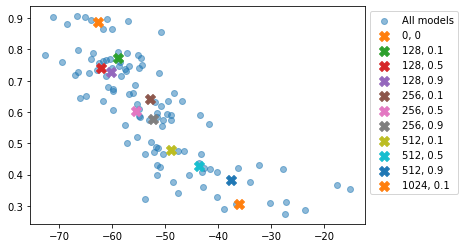

In [19]:
configlist = [[0,0]]+ [[2**x,y] for x in range(7,11) for y in [0.1,0.5,0.9]][:10]
eigs = []
test_accs = []
for ii, stat in enumerate(stats_data.reshape(-1)):
    if stat[0]<2000:
        test_accs.append(stat[-1])
        eigs.append(Hessians_eig.reshape(-1)[ii])
plt.scatter(eigs,test_accs,label = "All models",alpha = 0.5,marker="o")
label_list = [str(x[0])+", "+str(x[1]) for x in configlist]

for jj in range(11):
    eigs = []
    test_accs = []
    for ii, stat in enumerate(stats_data[jj]):
        if stat[0]<2000:
            test_accs.append(stat[-1])
            eigs.append(Hessians_eig[jj][ii])
    plt.scatter(np.mean(eigs),np.mean(test_accs),label = label_list[jj], marker="X", s=100)
plt.legend(bbox_to_anchor=(1, 1))
plt.savefig("figures/acc_eig.png",dpi=200,bbox_inches='tight')